In [2]:
# ============ Necessary libraries have been imported for you aleadry =============
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
%matplotlib inline
import kagglehub
import cv2
'''
You may include more libraries, if you want to
'''

'\nYou may include more libraries, if you want to\n'

In [4]:
BATCH_SIZE =128 # DEFINE YOUR BATCH SIZE HERE

<hr>

Autoencoder for image segmentation

<hr>

This task involves segmenting brain tumors from MRI scans using an autoencoder. The goal is to train a model that can accurately segment tumors, indicated by binary masks, from MRI images. Your model should be symmetrical, and input-output resolutions must remain consistent, achieved via appropriate padding.

### **Task 1: Dataset Prep**
- You'll be using `brain-tumor-segmentation` dataset (you can access it from [here](https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation?resource=download))
- You may download it locally or use it's kaggle link. In either case, make sure you have an `image` and a `mask` directory containing the images and the masks respectively for the brain tumor.
- The dataset consists of `3065` PNGs with dimensions `512x512`.

In [6]:
## Uncomment below lines ONLY if you're using kaggle
brain_tumor_segmentation_path = kagglehub.dataset_download('nikhilroxtomar/brain-tumor-segmentation')
print(brain_tumor_segmentation_path)

/kaggle/input/brain-tumor-segmentation


In [38]:
image_dir = "/kaggle/input/brain-tumor-segmentation/images"# path/to/your/image/diretory
ground_truths_dir = "/kaggle/input/brain-tumor-segmentation/masks"#path/to/your/ground/truth/masks/directory

# Function for preprocessing images and masks
def preprocessing(image, mask):
    '''
    The purpose of this function is to apply necessary preprocessing steps to both the input images
    and their corresponding ground truth masks before they are used for model training.
    '''
    # ============ Your code here ============= #

    image = np.array(image)  
    mask = np.array(mask)   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
    image = cv2.resize(image, (256, 256))#cnn model needs it
    mask = cv2.resize(mask, (256, 256))
    image = image.astype(np.float32) / 255.0#norm
    mask = (mask > 128).astype(np.float32)
    image = np.expand_dims(image, axis=-1)

    return image, mask


In [39]:
# Load images and ground truths
data = []
ground_truths = []

'''
1. Load all image files and the corresponding ground truth mask files from their respective directories.
2. Read the images and masks and apply pre-processing (if any).
3. Append the preprocessed images to the `data` list and the corresponding masks to the `ground_truths`
   list (both list have initialized above).

Make sure each image correctly corresponds to its mask.
'''
# ============ Your code here ============= 

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(ground_truths_dir))

for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(ground_truths_dir, mask_file)
    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    
    proc_image, proc_mask = preprocessing(image, mask)
    data.append(proc_image)
    ground_truths.append(proc_mask)


In [40]:
'''
1. Create a train-val-test split using DataLoader (ideally 70% test, 20% val, and 10% test
   would be okay but upto you to come up with your own split composition).
2. You may use train_test_split() function (imported above) for splitting, but if you're
   comfortable with split strategies, that's totally fine.
3. Once splitted, use DataLoader class to load the datasets.
'''

class BrainTumorSegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            img, mask = self.transform(img, mask)
        img_tensor = torch.tensor(img).permute(2, 0, 1).float()
        mask_tensor = torch.tensor(mask).unsqueeze(0).float()
        return img_tensor, mask_tensor

full_dataset= BrainTumorSegmentationDataset(data, ground_truths)
n= len(full_dataset)
indices= list(range(n))
train_idx, temp_idx= train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx= train_test_split(temp_idx, test_size=1/3, random_state=42)
train_dataset =Subset(full_dataset, train_idx)
val_dataset =Subset(full_dataset, val_idx)
test_dataset =Subset(full_dataset, test_idx)

BATCH_SIZE= 32
train_loader =DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader =DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)} ({len(train_dataset)/n*100:.2f}%)")
print(f"Validation samples: {len(val_dataset)} ({len(val_dataset)/n*100:.2f}%)")
print(f"Test samples: {len(test_dataset)} ({len(test_dataset)/n*100:.2f}%)")


# you may define your own variable names for loaders (names used above are just samples)

Train samples: 2144 (69.97%)
Validation samples: 613 (20.01%)
Test samples: 307 (10.02%)


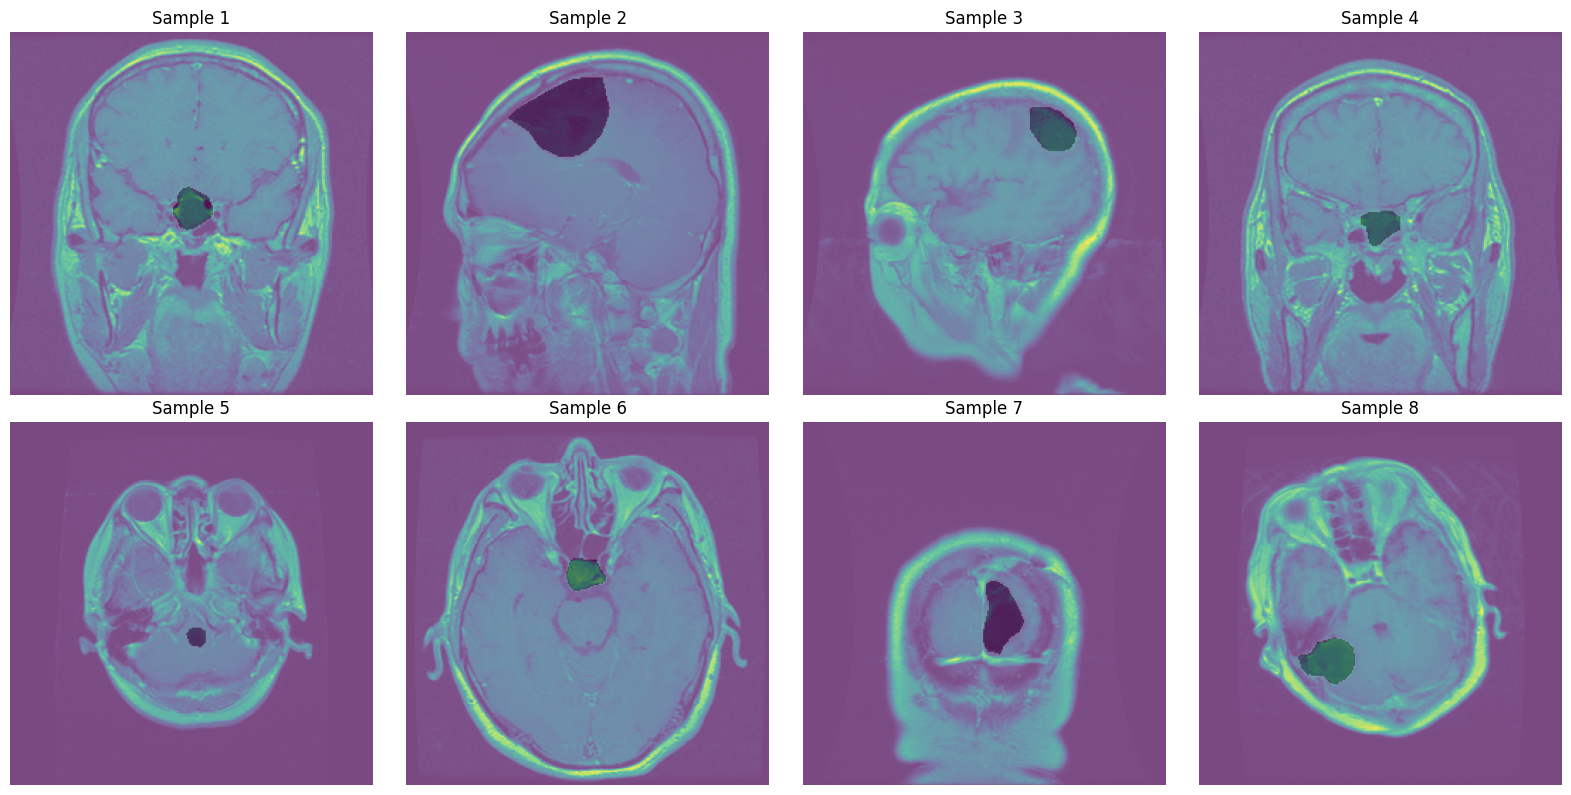

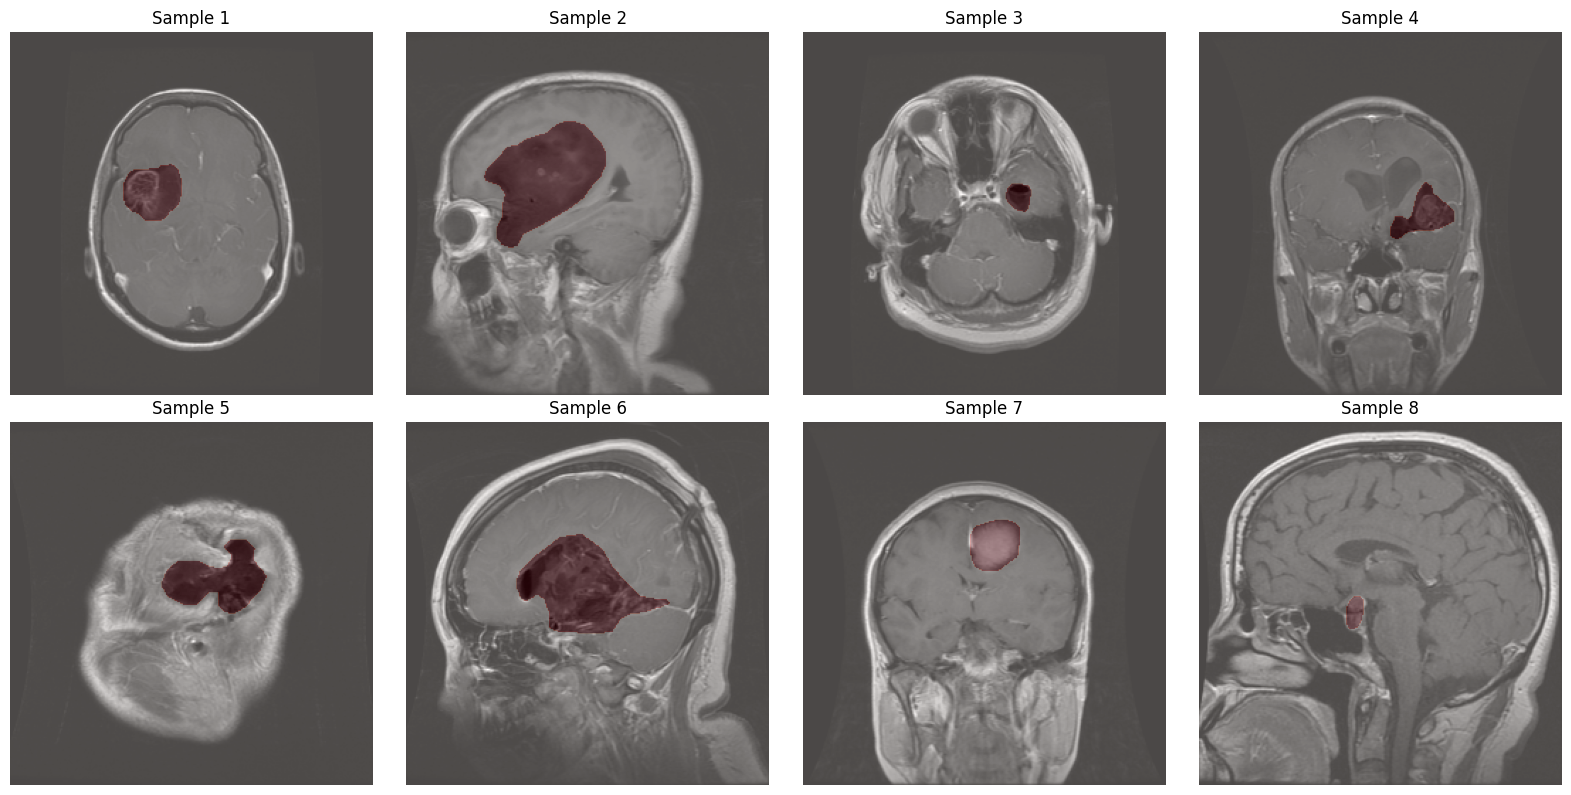

In [41]:
'''
Once you're done making the dataset, use the function below to vizualize it.
'''
def visualize_samples(images, masks):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=2, ncols=num_samples // 2, figsize=(16, 8))

    for i, (image, mask) in enumerate(zip(images, masks)):
        image = image.squeeze(0)
        mask = mask.squeeze(0)
        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, alpha=0.3, cmap='Reds')
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')
    plt.tight_layout()
    plt.show()


# Select 8 random samples from the training dataset
random_indices = np.random.choice(len(train_dataset), 8, replace=False)
random_samples = [(train_dataset[i][0], train_dataset[i][1]) for i in random_indices]

# Separate images and masks
random_images = [sample[0] for sample in random_samples]
random_masks = [sample[1] for sample in random_samples]

visualize_samples(random_images, random_masks)


### **Task 2: Implement the Dice Loss Function**  
In segmentation tasks, using MSE loss is often ineffective due to class imbalance, especially when the region of interest (e.g., brain tumors) is small. Hence, you are going to implement the Dice Loss by creating a custom `DiceLoss` class. Dice Loss is more suitable for segmentation tasks as it directly measures overlap between predictions and ground truth.  

Given:  
- **Predicted mask:** \( p \)  
- **Ground truth:** \( t \)  
- **Smoothing factor:** \( s \) (prevents division by zero)  

#### $L = 1 - \frac{2 \cdot \sum(p \cdot t) + s}{\sum(p^{2}) + \sum(t^{2}) + s}$

The smoothing factor $s$ is a small value (usually of the order of $1e^{-6}$).
For more details, see [this paper](https://arxiv.org/pdf/1606.04797.pdf) (page 6).  


In [42]:
class DiceLoss(nn.Module):
    def __init__(self,smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth=smooth


    def forward(self, prediction, target):
        # Code here
        prediction = prediction.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (prediction * target).sum()
        dice_coeff = (2. * intersection + self.smooth) / ((prediction**2).sum() + (target**2).sum() + self.smooth)
        return 1-dice_coeff

### **Task 3: Define Autoencoder for Brain Tumor segmentation**


In [44]:
class SegmentationAE(nn.Module):
    def __init__(self):
        super(SegmentationAE, self).__init__()

        # --- Encoder ---
        # Code here
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2) #16,128
        )
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  #32,64
        )
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2) #64,32
        )

        # --- Decoder ---
        # Code here 
        self.dec_conv1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2), 
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec_conv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2), 
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.dec_conv3 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),  
            nn.Sigmoid()  
        )

    def forward(self, x):
        # code here
        x = self.enc_conv1(x)
        x = self.enc_conv2(x)
        x = self.enc_conv3(x)
        x = self.dec_conv1(x)
        x = self.dec_conv2(x)
        x = self.dec_conv3(x)

# Instantiate randomly and print summary (size of your model, no. params and stuff)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationAE().to(device)
summary(model, input_size=(1, 256, 256), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 16, 256, 256]             160
              ReLU-2          [8, 16, 256, 256]               0
            Conv2d-3          [8, 16, 256, 256]           2,320
              ReLU-4          [8, 16, 256, 256]               0
         MaxPool2d-5          [8, 16, 128, 128]               0
            Conv2d-6          [8, 32, 128, 128]           4,640
              ReLU-7          [8, 32, 128, 128]               0
            Conv2d-8          [8, 32, 128, 128]           9,248
              ReLU-9          [8, 32, 128, 128]               0
        MaxPool2d-10            [8, 32, 64, 64]               0
           Conv2d-11            [8, 64, 64, 64]          18,496
             ReLU-12            [8, 64, 64, 64]               0
           Conv2d-13            [8, 64, 64, 64]          36,928
             ReLU-14            [8, 64,

### **Task 4: Define the Training Loop**  

- Print both the training and validation losses for each epoch.  
- Plot the training and validation loss curves, with epochs on the x-axis and losses on the y-axis, at the end of the training.  
- Save the best model as a `.pth` file using the `torch.save()` method. **Submit this file along with your notebook, naming it as `campus_id.pth`.**  
- After every 2ish epochs, visualize a grid displaying the Image | Ground Truth Mask | Predicted Mask.


Epoch 1/30 - Train Loss: 0.7757 | Val Loss: 0.6969
Epoch 2/30 - Train Loss: 0.7155 | Val Loss: 0.7022


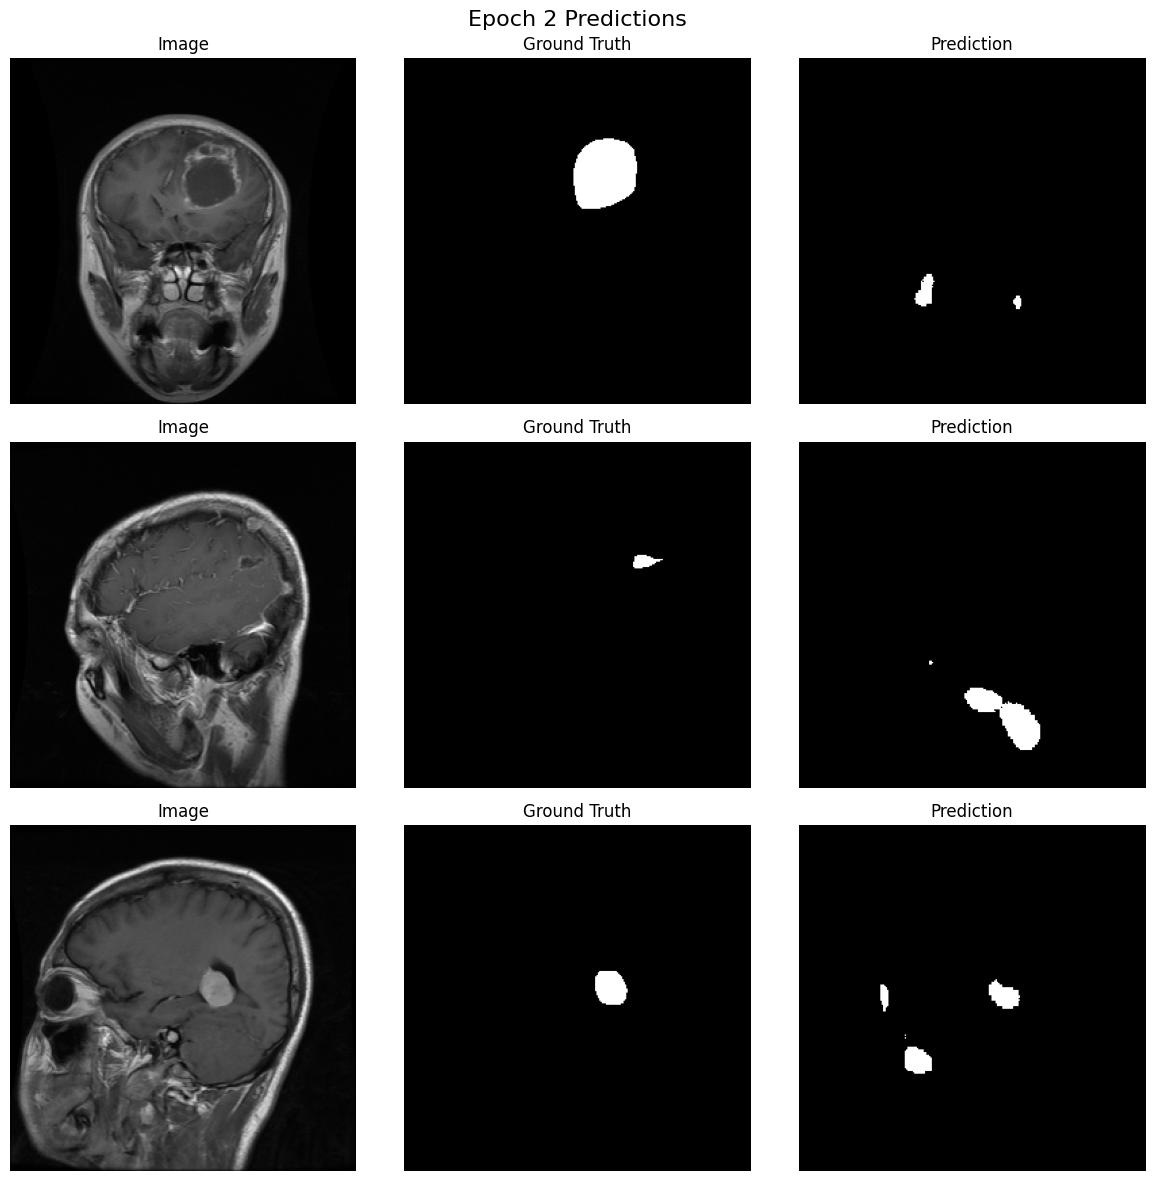

Epoch 3/30 - Train Loss: 0.6896 | Val Loss: 0.6882
Epoch 4/30 - Train Loss: 0.6469 | Val Loss: 0.5956


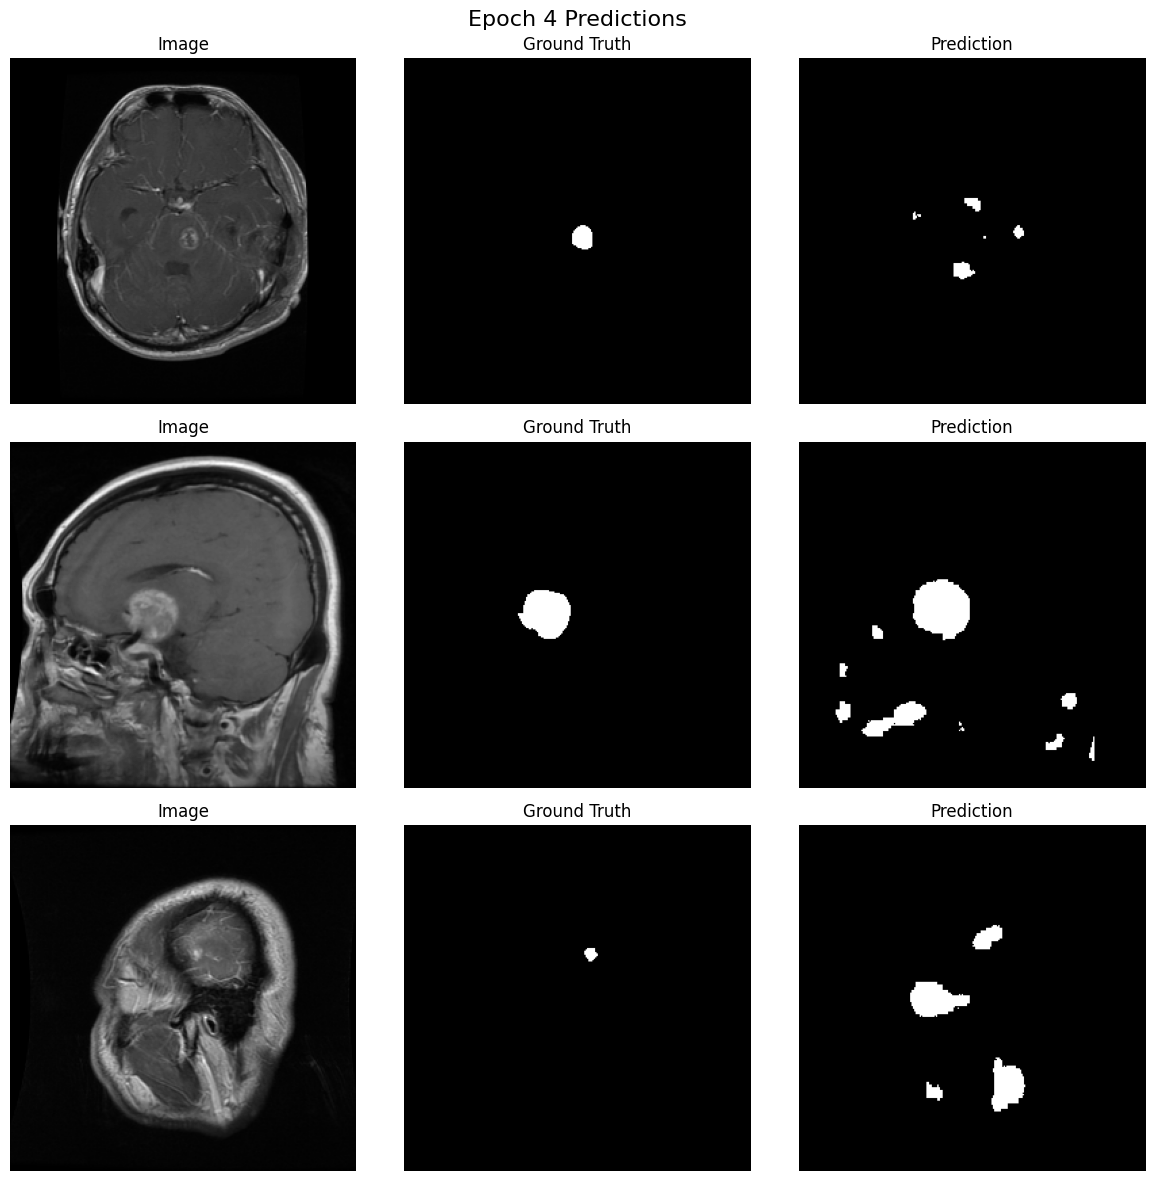

Epoch 5/30 - Train Loss: 0.6012 | Val Loss: 0.5673
Epoch 6/30 - Train Loss: 0.5587 | Val Loss: 0.5407


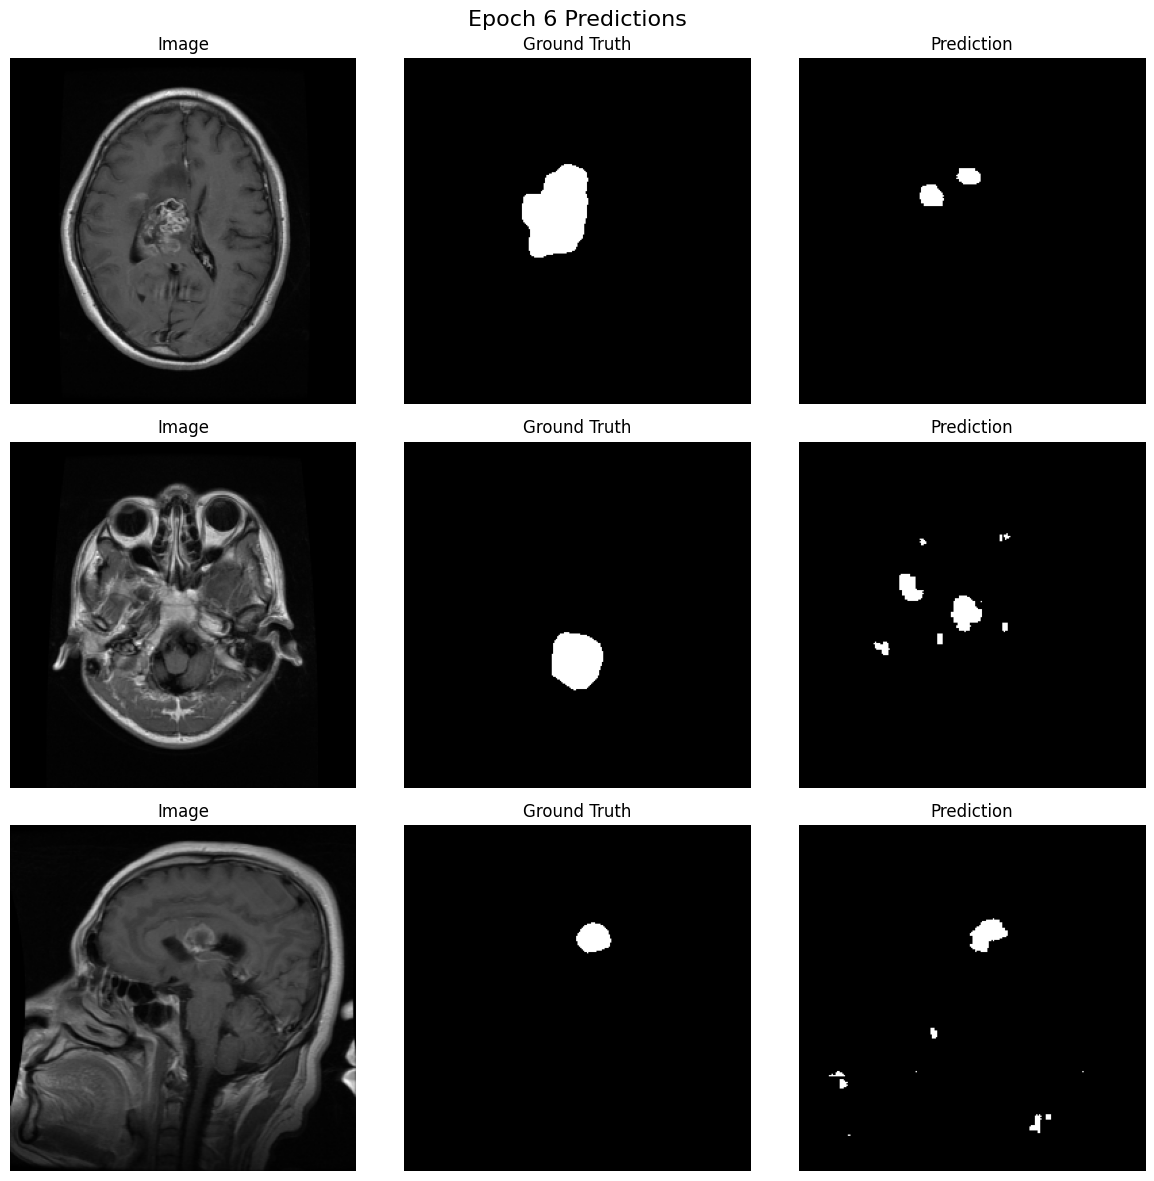

Epoch 7/30 - Train Loss: 0.5294 | Val Loss: 0.5577
Epoch 8/30 - Train Loss: 0.5027 | Val Loss: 0.5099


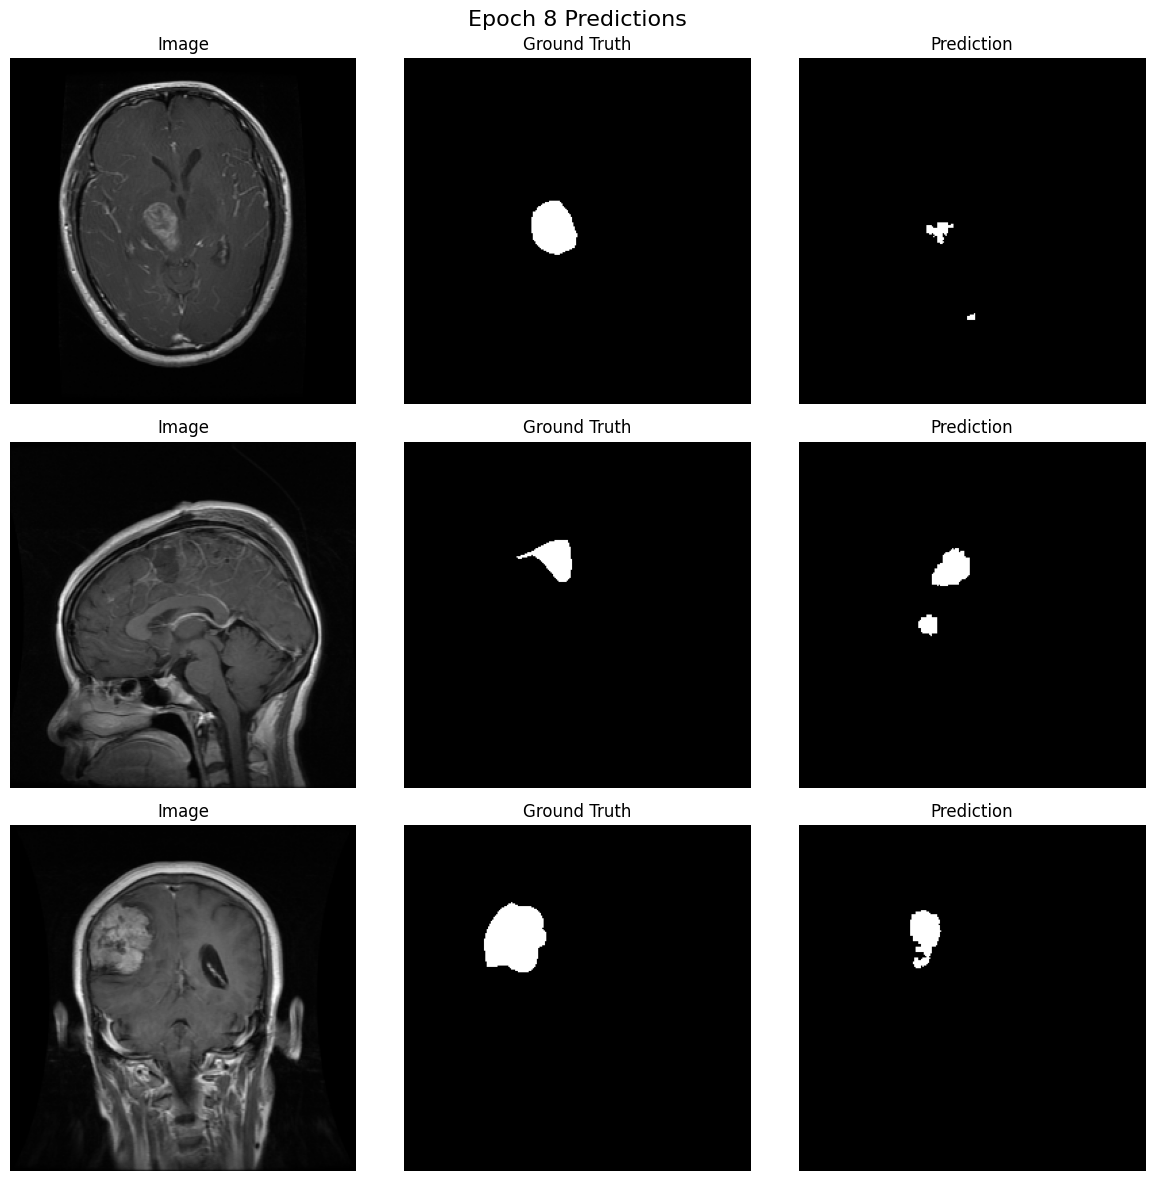

Epoch 9/30 - Train Loss: 0.4807 | Val Loss: 0.4779
Epoch 10/30 - Train Loss: 0.4529 | Val Loss: 0.4856


Epoch 11/30 - Train Loss: 0.4366 | Val Loss: 0.4355
Epoch 12/30 - Train Loss: 0.4232 | Val Loss: 0.4500


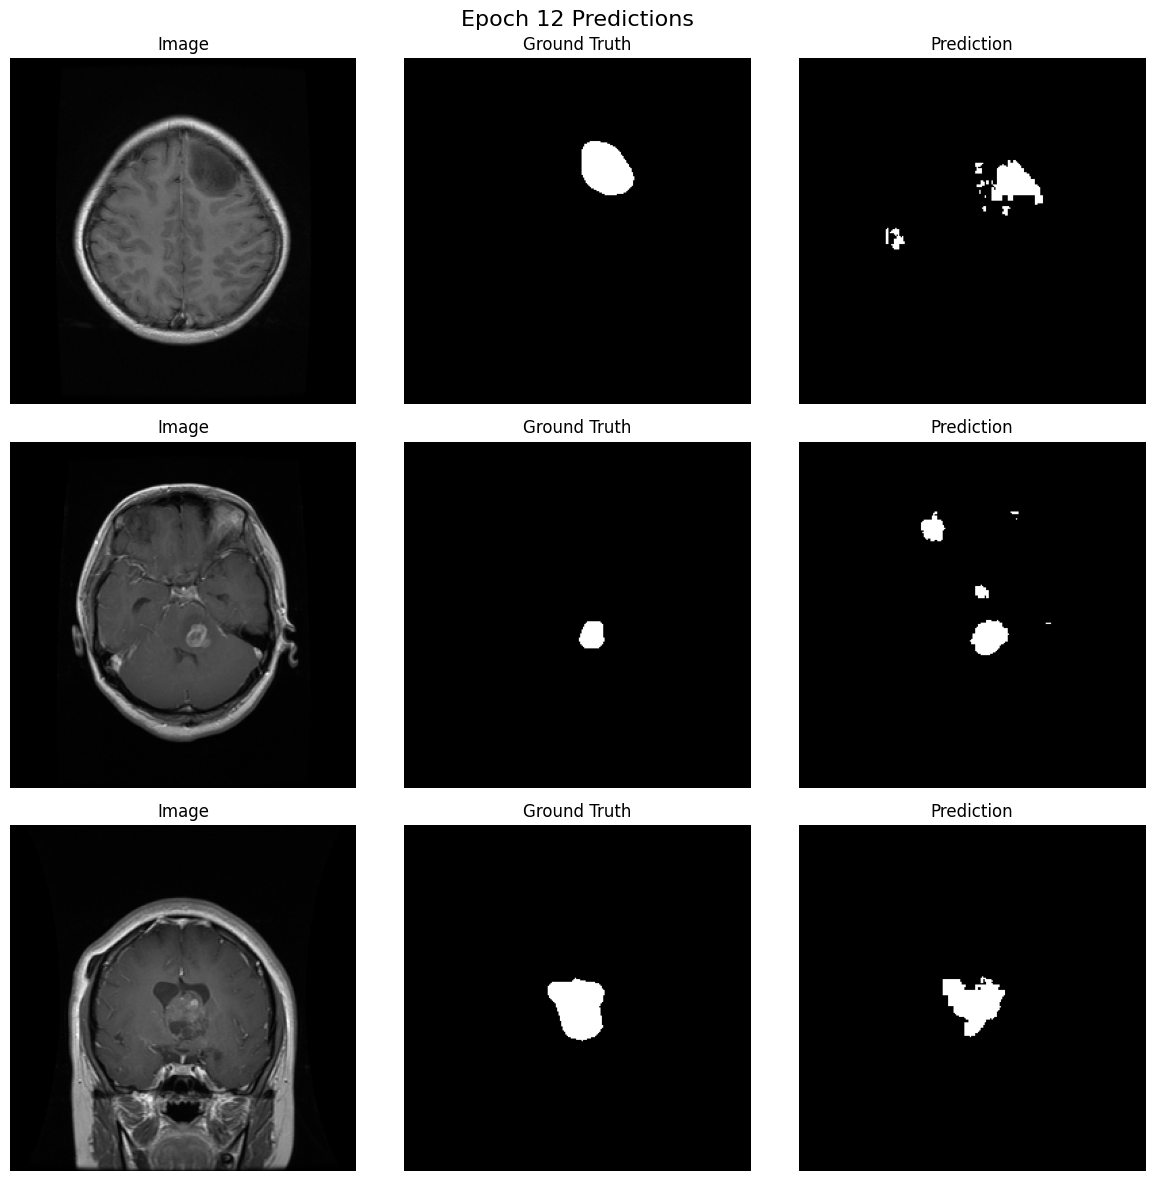

Epoch 13/30 - Train Loss: 0.4030 | Val Loss: 0.4142
Epoch 14/30 - Train Loss: 0.3897 | Val Loss: 0.4716


Epoch 15/30 - Train Loss: 0.3806 | Val Loss: 0.4188
Epoch 16/30 - Train Loss: 0.3694 | Val Loss: 0.3992


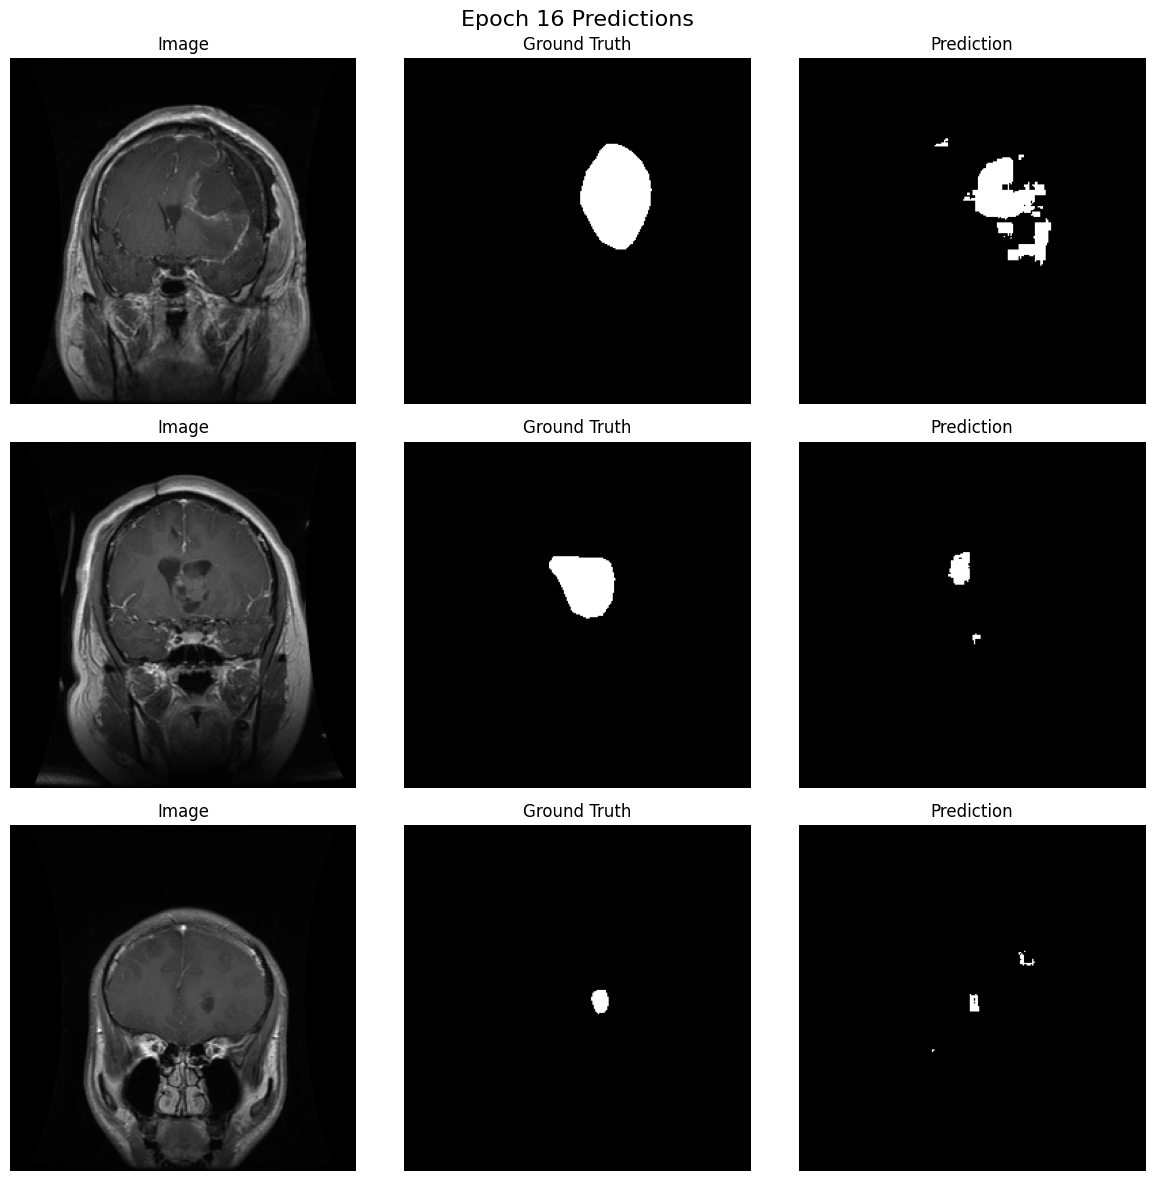

Epoch 17/30 - Train Loss: 0.3560 | Val Loss: 0.4033
Epoch 18/30 - Train Loss: 0.3437 | Val Loss: 0.4049


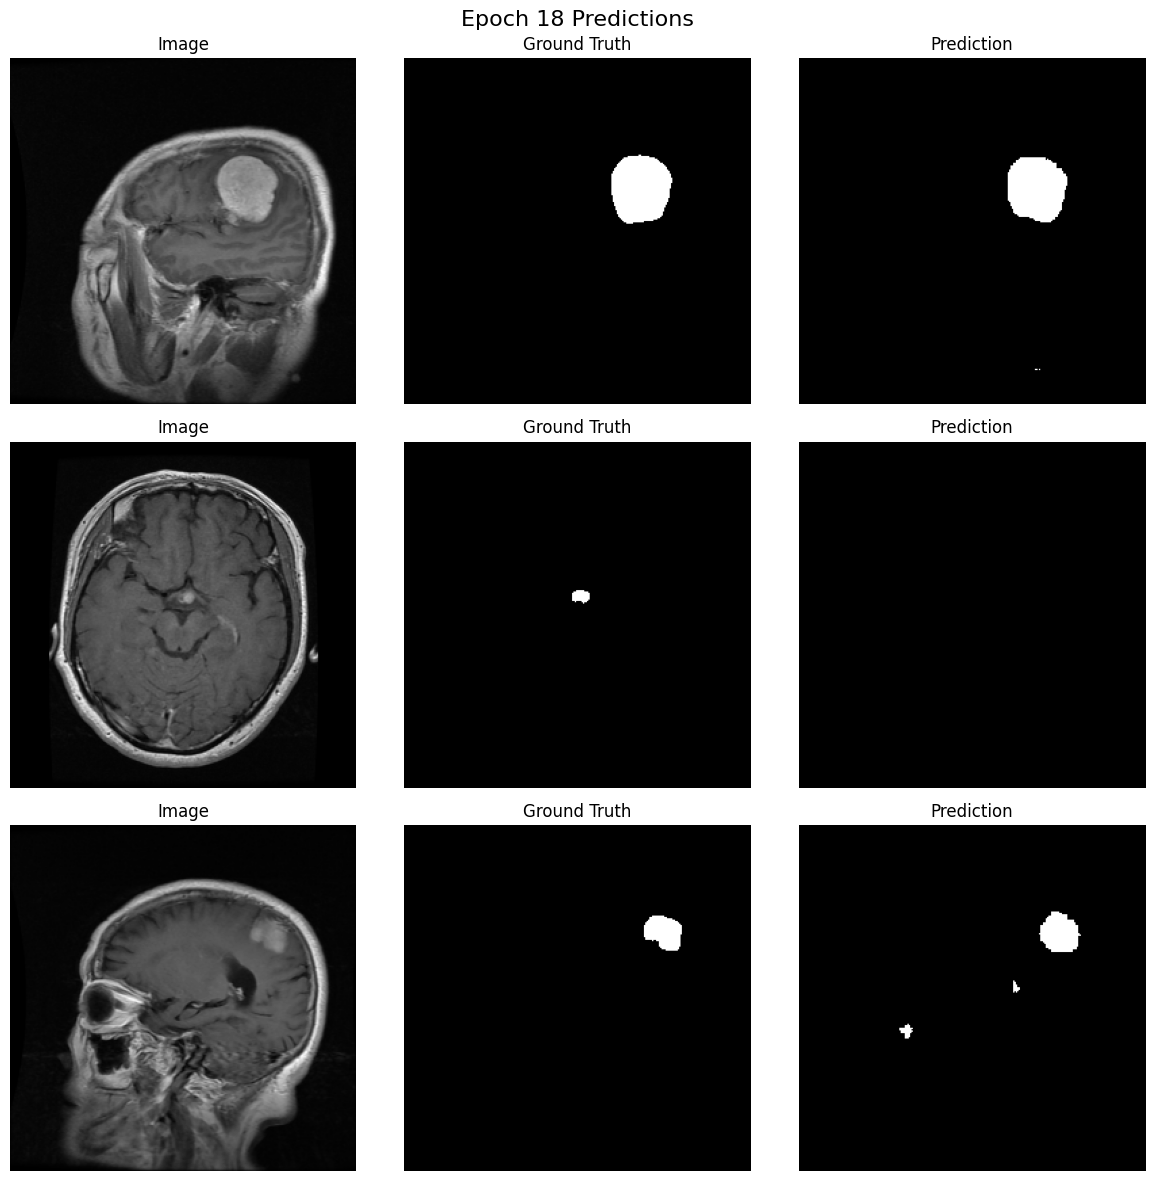

Epoch 19/30 - Train Loss: 0.3383 | Val Loss: 0.3762
Epoch 20/30 - Train Loss: 0.3278 | Val Loss: 0.3928


Epoch 21/30 - Train Loss: 0.3210 | Val Loss: 0.3722
Epoch 22/30 - Train Loss: 0.3042 | Val Loss: 0.3710


Epoch 23/30 - Train Loss: 0.3011 | Val Loss: 0.3690
Epoch 24/30 - Train Loss: 0.2906 | Val Loss: 0.3590


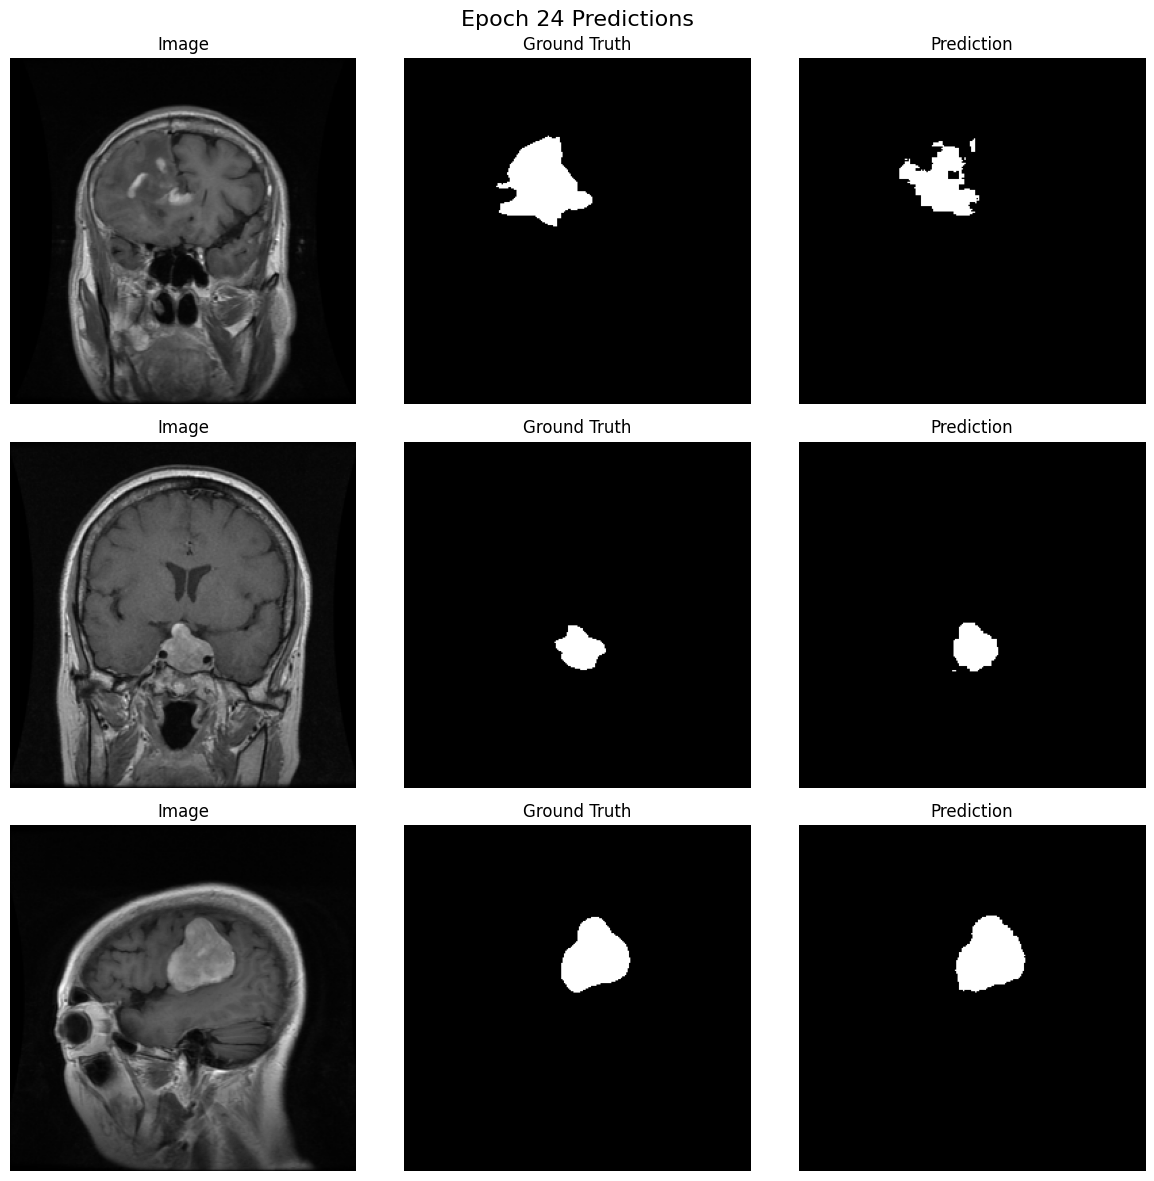

Epoch 25/30 - Train Loss: 0.2850 | Val Loss: 0.3616
Epoch 26/30 - Train Loss: 0.2768 | Val Loss: 0.3664


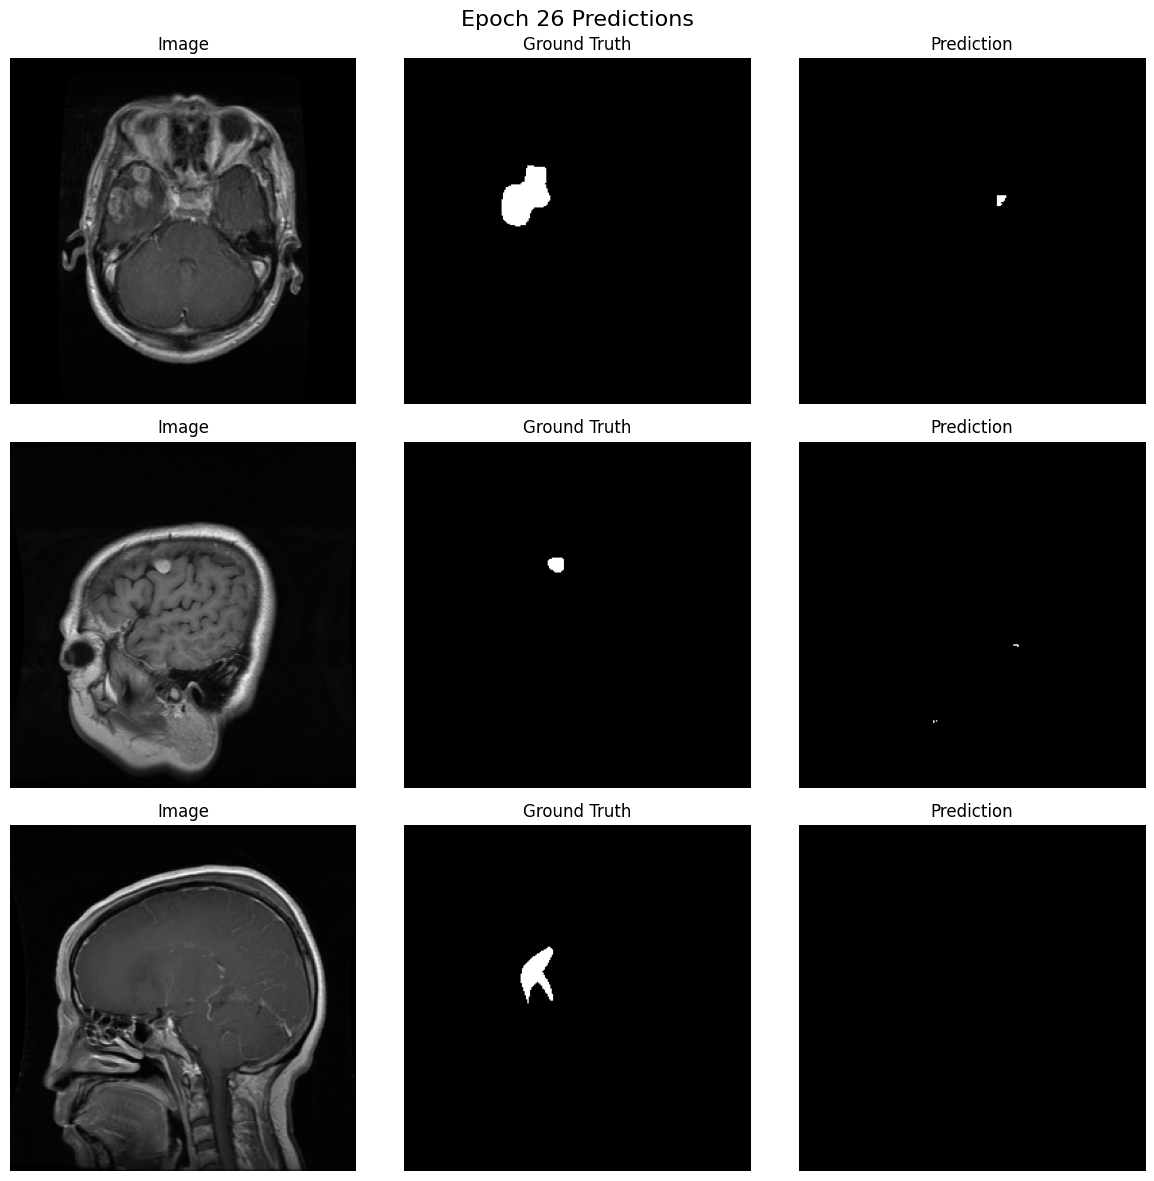

Epoch 27/30 - Train Loss: 0.2740 | Val Loss: 0.3567
Epoch 28/30 - Train Loss: 0.2588 | Val Loss: 0.3683


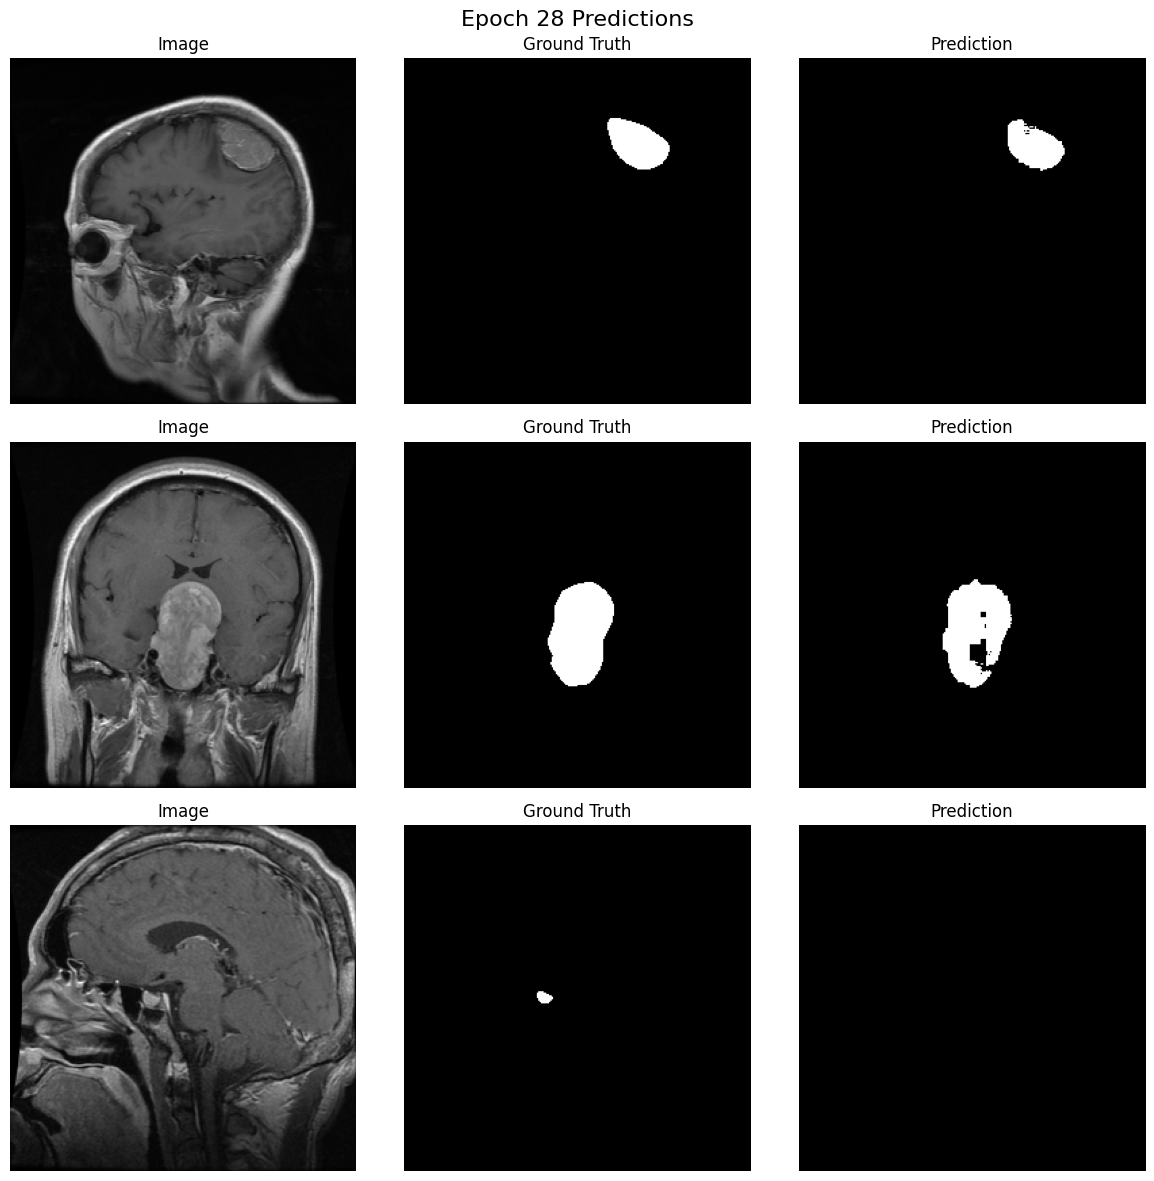

Epoch 29/30 - Train Loss: 0.2583 | Val Loss: 0.3802
Epoch 30/30 - Train Loss: 0.2483 | Val Loss: 0.3628


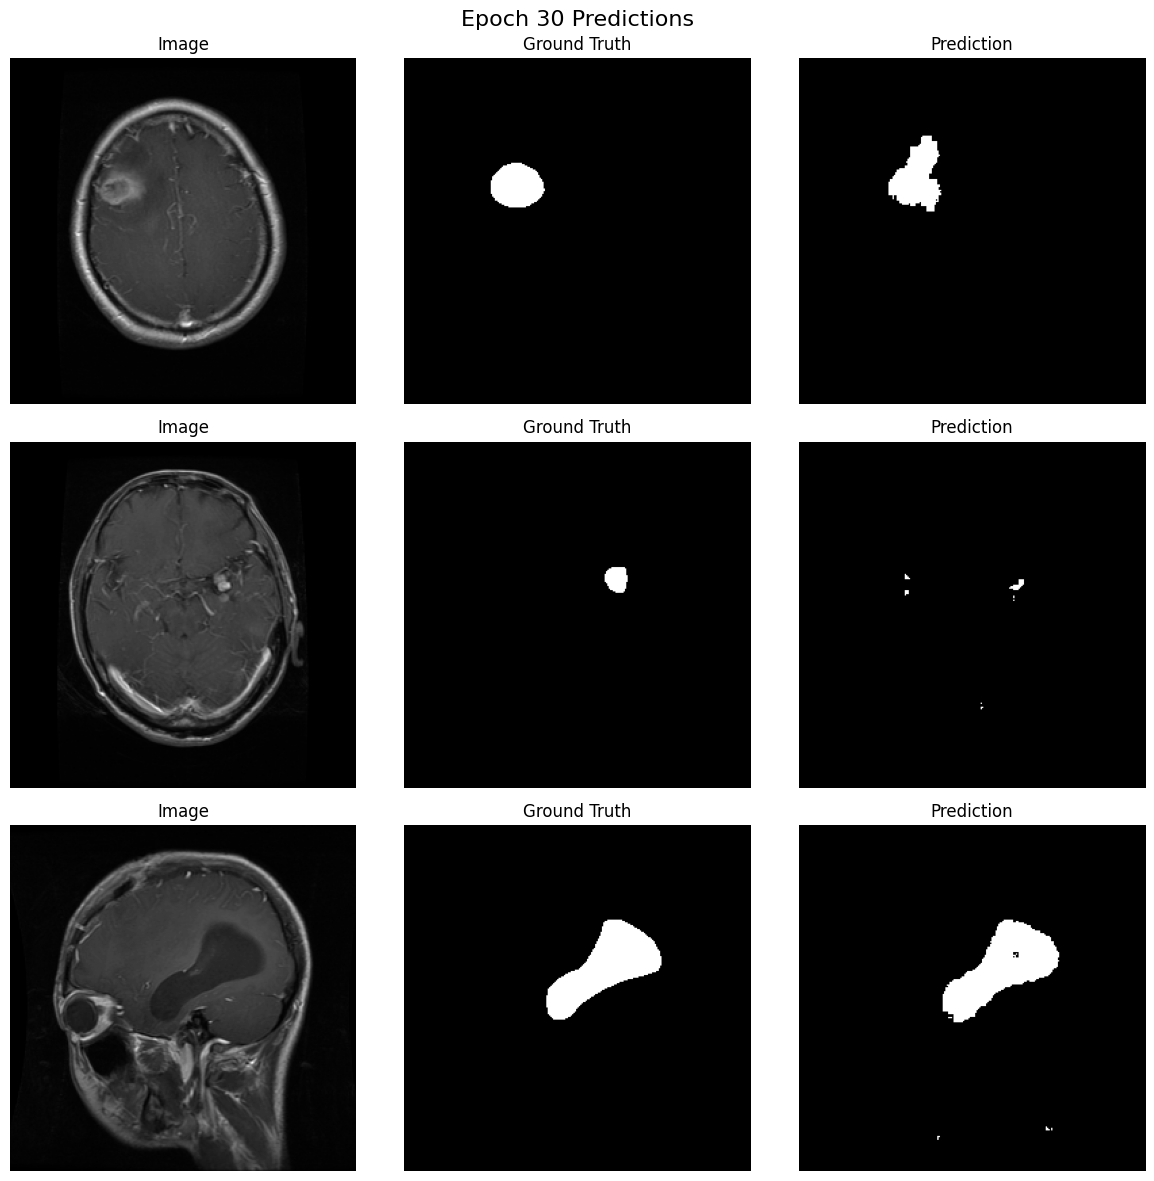

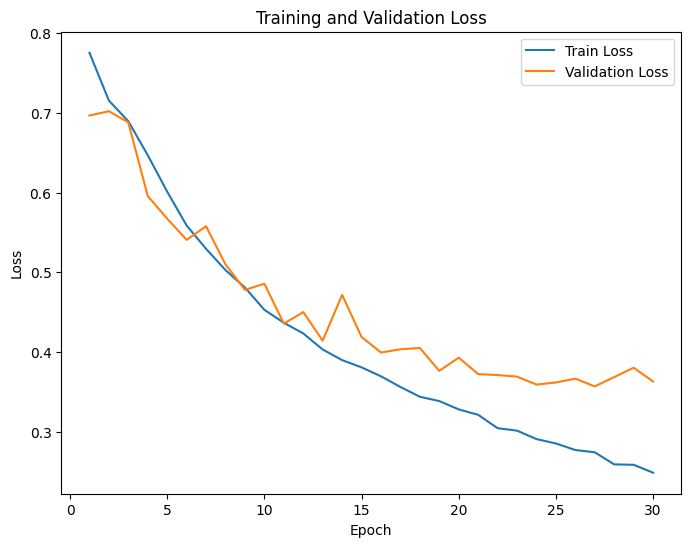

In [47]:

def train_segmentation_ae(model, train_loader, val_loader, num_epochs=30, lr=1e-3):
    criterion = DiceLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    #t
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_train_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)  
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        #e
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), "campus_id.pth")
        if epoch % 2 == 0:
            visualize_predictions(model, train_loader, epoch)
    
    plt.figure(figsize=(8,6))
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

def visualize_predictions(model, loader, epoch):#some

    model.eval()
    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)
    with torch.no_grad():
        preds = model(images)
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()
    num_samples = min(3, images.shape[0])
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    for i in range(num_samples):
        img = images[i, 0, :, :]  
        gt = masks[i, 0, :, :]
        pred = (preds[i, 0, :, :] > 0.5).astype(np.float32)
        
        axes[i, 0].imshow(img, cmap='gray')
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(gt, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(pred, cmap='gray')
        axes[i, 2].set_title("Prediction")
        for ax in axes[i]:
            ax.axis("off")
    plt.suptitle(f"Epoch {epoch} Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationAE().to(device)
train_segmentation_ae(model, train_loader, val_loader, num_epochs=30, lr=1e-3)


### **Task 5: Evaluate Your Autoencoder's Segmentation**  

- Select and visualize **10 random samples** from the test set, displaying the **Image | Ground Truth Mask | Predicted Mask** in a grid format.  
- Compute the **Dice Coefficient** and **Intersection over Union (IoU)** scores for the entire test dataset.  

#### **Mathematical Expressions:**  
- **Dice Coefficient (DICE):**  $\text{DICE} = \frac{2 \times \sum(p \cup t)}{\sum(p) + \sum(t)}$

- **Intersection over Union (IoU):**  $\text{IoU} = \frac{\sum(p \cup t)}{\sum(p \cap t)}$

Where:  
- $p$ = Predicted mask (binary)  
- $t$ = Ground truth mask (binary)  

Make sure to print the computed scores.

In [48]:
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = (2 * intersect) / total_sum if total_sum > 0 else 1.0
    return dice

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou_value = intersect / union if union > 0 else 1.0
    return iou_value

Test Dice Coefficient: 0.5374
Test IoU: 0.4247


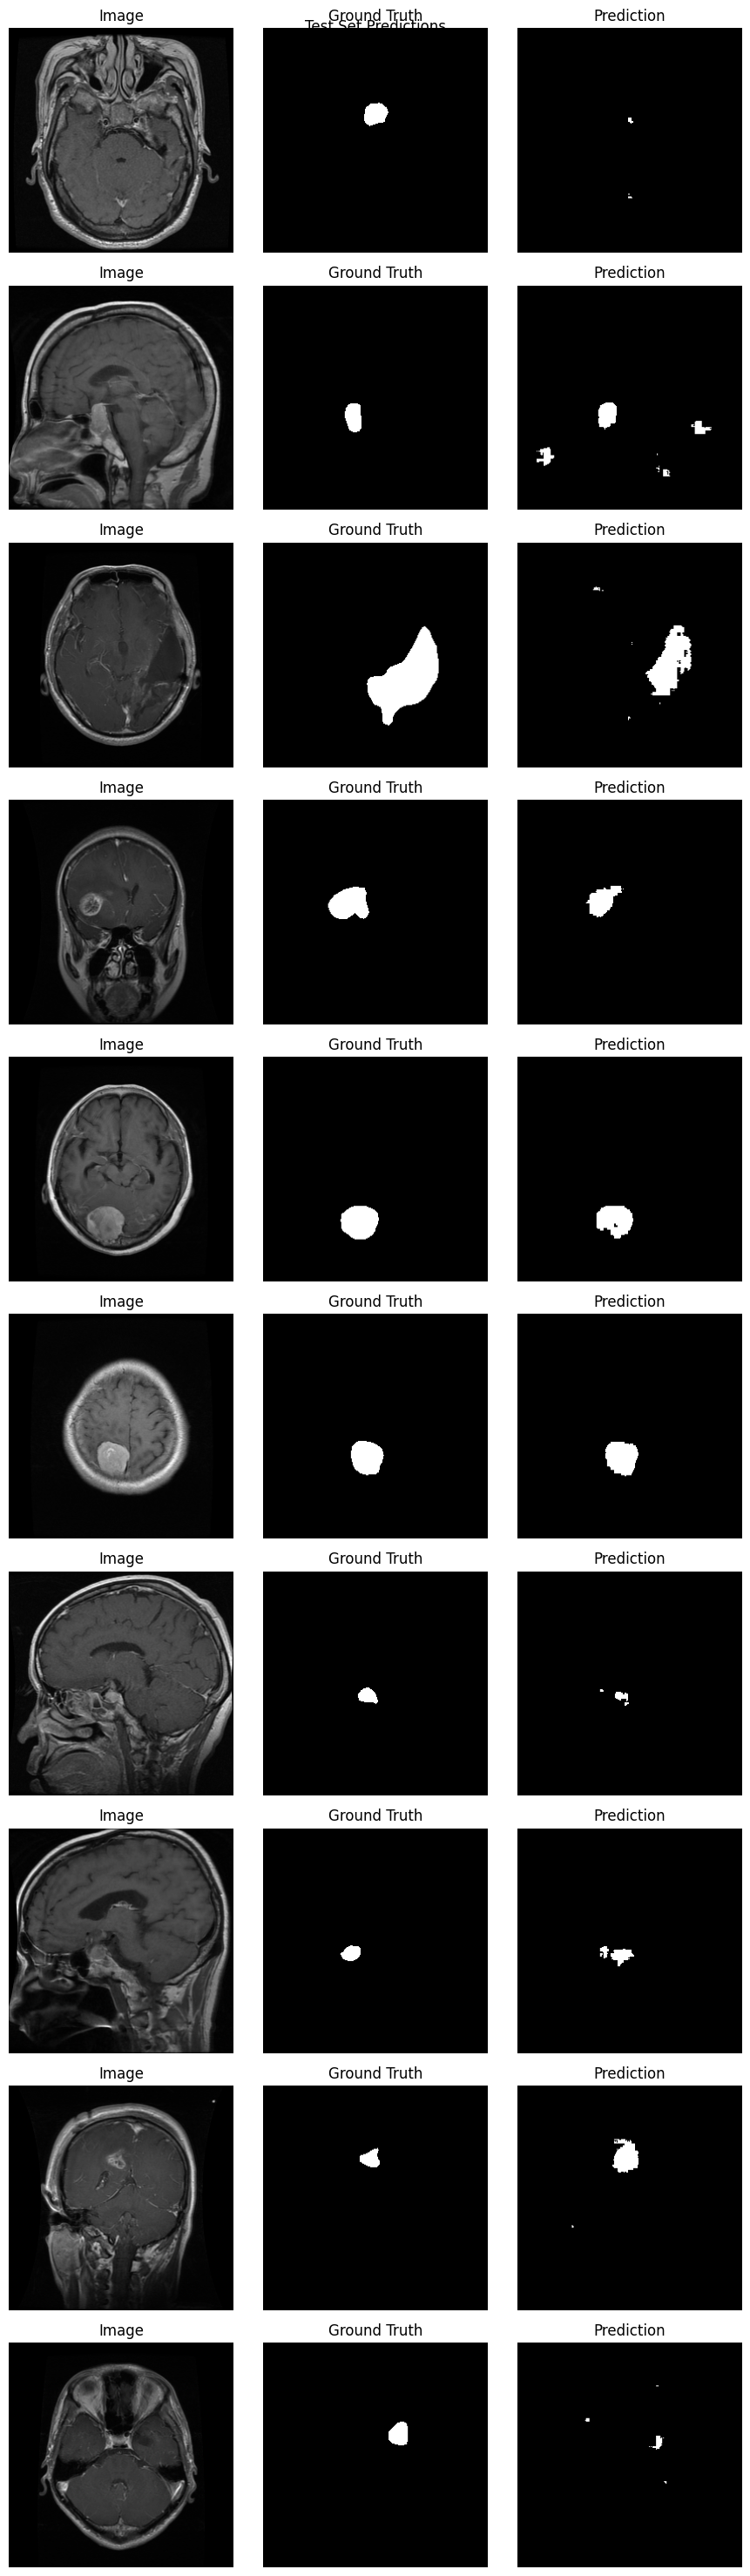

In [49]:
## Your code here
def evaluate_segmentation_ae(model, test_loader, num_samples_to_visualize=10):
    model.eval()
    all_dice = []
    all_iou = []
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = (outputs > 0.5).float().cpu().numpy()
            gt = masks.cpu().numpy()
            for b in range(len(images)):
                dice_score = dice_coef(gt[b, 0], preds[b, 0])
                iou_score = iou(gt[b, 0], preds[b, 0])
                all_dice.append(dice_score)
                all_iou.append(iou_score)

    mean_dice = np.mean(all_dice)
    mean_iou = np.mean(all_iou)
    print(f"Test Dice Coefficient: {mean_dice}")
    print(f"Test IoU: {mean_iou}")
    indices = np.random.choice(len(test_loader.dataset), num_samples_to_visualize, replace=False)
    fig, axes = plt.subplots(num_samples_to_visualize, 3, figsize=(9, 3 * num_samples_to_visualize))
    model.eval()
    for i, idx in enumerate(indices):
        img, gt_mask = test_loader.dataset[idx]
        img_cuda = img.unsqueeze(0).to(device)  
        with torch.no_grad():
            pred = model(img_cuda)
        pred_bin = (pred > 0.5).float().cpu().numpy()[0, 0]  
        img_np = img.numpy()[0]  
        gt_mask_np = gt_mask.numpy()[0] 

        axes[i, 0].imshow(img_np, cmap='gray')
        axes[i, 0].set_title("Image")
        axes[i, 1].imshow(gt_mask_np, cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 2].imshow(pred_bin, cmap='gray')
        axes[i, 2].set_title("Prediction")

        for ax in axes[i]:
            ax.axis('off')
    plt.suptitle("Test Set Predictions")
    plt.tight_layout()
    plt.show()

evaluate_segmentation_ae(model, test_loader, num_samples_to_visualize=10)


## Submissions
- Notebook.
- Best model's `.pth` file. Rename it to `campus_id.pth`.